In [1]:
import random
import pandas as pd
import imagesize
import numpy as np
import matplotlib.pyplot  as plt
from pathlib import Path
from PIL import Image
from sklearn.decomposition import PCA

# Data Exploration

## Identify Image resolutions for optimal image size

In [ ]:
# Identify Image Resolutions to identify how do resize the images
path_images = 'filtered_cropped_images_saved/'

# Get the Image Resolutions
images = [image.name for image in Path(path_images).iterdir() if image.suffix == ".png"]

# select random 1000 images to plot
random_selection = random.sample(images, 3000)

# get the shape of the image
image_meta = {}
for i in random_selection:
    image_meta[str(i)] = imagesize.get(path_images+i)

# Convert it to Dataframe and compute aspect ratio
image_meta_df = pd.DataFrame.from_dict([image_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns')
image_meta_df[["Width", "Height"]] = pd.DataFrame(image_meta_df["Size"].tolist(), index=image_meta_df.index)
image_meta_df["Aspect Ratio"] = round(image_meta_df["Width"] / image_meta_df["Height"], 2)


In [ ]:
# define the target label
image_meta_df['target'] = image_meta_df['FileName'].str.extract(r'_(.*?)_')
image_meta_df['label'] = image_meta_df['target'].isin(["leukocyte", "red blood cell"]).astype(int)
image_meta_df.head()

,FileName,Size,Width,Height,Aspect Ratio,target,label
0,259da25f-40f3-4d37-bca9-a9c807af1547_red blood...,"(103, 85)",103,85,1.21,red blood cell,1
1,ac8df764-c8d8-4312-916d-70bfb37574b4_red blood...,"(122, 104)",122,104,1.17,red blood cell,1
2,8490c623-3d88-4532-baf5-0d266a45b16f_red blood...,"(97, 109)",97,109,0.89,red blood cell,1
3,71925778-a26e-483e-a07c-f3aaf740122a_red blood...,"(126, 121)",126,121,1.04,red blood cell,1
4,9ebd623d-5534-4dd9-bff8-cdedf322db35_red blood...,"(114, 105)",114,105,1.09,red blood cell,1


**Observation**:

* The images range from from small ones to a high-resolution ones
* Images have different aspect ratios

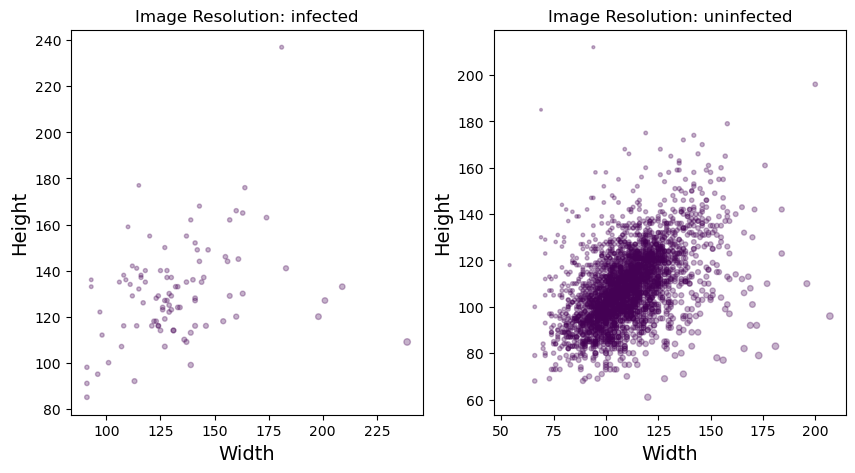

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Split images based on target classes
class_0 = image_meta_df[image_meta_df['label'] == 0]
class_1 = image_meta_df[image_meta_df['label'] == 1]

# define plot parameters
alpha=0.3


axs[0].scatter(
    class_0.Width,
    class_0.Height,
    c=class_0["label"],
    alpha=alpha,
    s=class_0["Aspect Ratio"] * 10,
    picker=True
)

axs[0].set_title("Image Resolution: infected")
axs[0].set_xlabel("Width", size=14)
axs[0].set_ylabel("Height", size=14)

axs[1].scatter(
    class_1.Width,
    class_1.Height,
    c=class_1["label"],
    alpha=alpha,
    s=class_1["Aspect Ratio"] * 10,
    picker=True
)

axs[1].set_title("Image Resolution: uninfected")
axs[1].set_xlabel("Width", size=14)
axs[1].set_ylabel("Height", size=14)

plt.show()

## Average Image

Plot the average image to see if there is a difference between the two classes.

In [ ]:
folder_clean_data = "Image Numpys_saved/"

# load data
X_train = np.load(folder_clean_data + 'X_train_resampled.npy')
y_train = np.load(folder_clean_data + 'y_train_resampled.npy')
X_val = np.load(folder_clean_data + 'X_val_resampled.npy')
y_val = np.load(folder_clean_data + 'y_val_resampled.npy')
X_test = np.load(folder_clean_data + 'X_test_pix.npy')
y_test = np.load(folder_clean_data + 'y_test.npy')

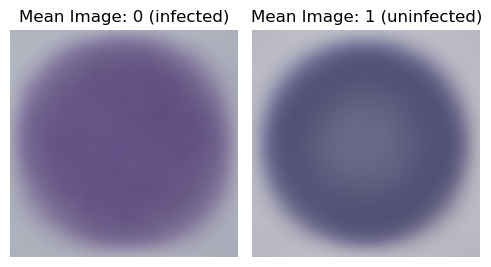

In [ ]:
import matplotlib.pyplot as plt

def find_mean_img(X, y, size=(128, 128, 3)):
    
    # Split images based on target classes
    class_0 = X[y == 0]
    class_1 = X[y == 1]

    # Compute the mean image for each class
    mean_class_0 = np.mean(class_0, axis=0)
    mean_class_1 = np.mean(class_1, axis=0)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(5, 5))

    # Plot mean image for class 0
    axs[0].imshow(mean_class_0.reshape(size), vmin=0, vmax=255, cmap='Greys_r')
    axs[0].set_title('Mean Image: 0 (infected)')
    axs[0].axis('off')

    # Plot mean image for class 1
    axs[1].imshow(mean_class_1.reshape(size), vmin=0, vmax=255, cmap='Greys_r')
    axs[1].set_title('Mean Image: 1 (uninfected)')
    axs[1].axis('off')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

    return mean_class_0, mean_class_1

mean_class_0, mean_class_1 = find_mean_img(X_test, y_test)

## Eigenimages/ PCA

Extract the features that describe the infected and uninfected malaria cells the best.

In [ ]:
X_train_reshaped = X_train.reshape(X_train.shape[0],-1)

pca = PCA(n_components=0.90) # perserve 90% of the variance
pca.fit(X_train_reshaped)

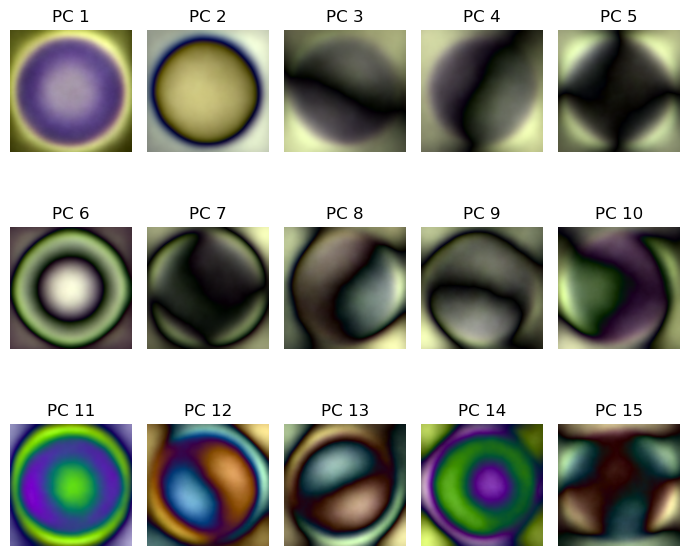

In [ ]:
# plot some of the principal components
fig = plt.figure(figsize=(7,10))

# plot the first 15 principal components
for i in range(15):
    plt.subplot(5, 5, i + 1)
    scaled_component = np.abs(pca.components_[i])  # Take the absolute values
    scaled_component = (scaled_component - np.min(scaled_component)) / (np.max(scaled_component) - np.min(scaled_component))  # Rescale to the range [0, 1]
    plt.imshow(scaled_component.reshape(128, 128, 3), cmap=plt.cm.gray)
    plt.title('Principal Component 1')
    plt.axis('off')
    plt.title(f'PC {i+1}')
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()